# Desafio 4 - LSTM Bot QA

## Importación de librerías

In [1]:
import re
import os
import zipfile

import numpy as np
import pandas as pd
import gdown
import json
import contractions

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.config import list_physical_devices
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.regularizers import l2
from keras.models import Model
from tensorflow.keras.layers import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.layers import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.layers import Bidirectional, Attention, Concatenate, Input, LSTM, Embedding, Dense
from keras.regularizers import l2

from utils import *
from words_embeddings import FasttextEmbeddings

2024-10-20 00:11:23.165758: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-20 00:11:23.322098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 00:11:23.383350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 00:11:23.399734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 00:11:23.509617: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = list_physical_devices('GPU')

if gpus:
    print(f"Available GPU(s): {gpus}")
else:
    print("No GPU detected. Using CPU instead.")

Available GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1729397486.513589  221738 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729397486.567615  221738 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729397486.568189  221738 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Carga de datos

In [3]:
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("Dataset already downloaded")

Dataset already downloaded


In [4]:
text_file = "data_volunteers.json"

with open(text_file) as f:
    data = json.load(f)

In [5]:
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

## Data preparation

Se comienza la preparación de los datos realizando una limpieza y separación de estos.

In [6]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []

max_length = 8
skipped = 0

for line in data:
    for i in range(len(line['dialog']) - 1):
        # Clean and extract the input and output sentences
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i + 1]['text'])

        # If either sentence exceeds the maximum allowed length, skip them
        if len(chat_in.split()) > max_length or len(chat_out.split()) > max_length:
            skipped += 1
            continue

        # Assign the cleaned sentences to input and output variables
        input_sentence = chat_in
        output_sentence = chat_out

        # Add the <sos> and <eos> tokens to the output sentence
        output_sentence_input = '<sos> ' + output_sentence
        output_sentence_output = output_sentence + ' <eos>'

        # Append the processed sentences to their respective lists
        input_sentences.append(input_sentence)
        output_sentences_inputs.append(output_sentence_input)
        output_sentences.append(output_sentence_output)

print("Number of rows used:", len(input_sentences))
print("Number of rows skipped:", skipped)

Number of rows used: 8112
Number of rows skipped: 5400


In [7]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you', 'not bad and you <eos>', '<sos> not bad and you')

Se tokeniza el texto de entrada para obtener: `word2idx_inputs` y `max_input_len`.

In [8]:
# Define the maximum vocabulary size
MAX_VOCAB_SIZE = 8000

# Tokenizer for input sentences
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<unk>')
input_tokenizer.fit_on_texts(input_sentences)

# Convert input sentences to sequences of integers
input_integer_sequences = input_tokenizer.texts_to_sequences(input_sentences)

# Create word-to-index mapping for inputs
word2idx_inputs = input_tokenizer.word_index

# Get the maximum length of input sequences
max_input_len = max(len(s) for s in input_integer_sequences)

print(f"Words in the input vocabulary: {len(word2idx_inputs)}")
print(f"Maximum input sequence length: {max_input_len}")

Words in the input vocabulary: 2413
Maximum input sequence length: 8


Se tokenizan las respuestas para obtener: `word2idx_outputs`, `max_out_len` y `num_words_output`.

In [9]:
# Tokenizer for output sentences
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<unk>', filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(output_sentences + ['<sos>', '<eos>'])


# Convert output sentences to sequences of integers
decoder_input_sequences = output_tokenizer.texts_to_sequences(output_sentences_inputs)
decoder_output_sequences = output_tokenizer.texts_to_sequences(output_sentences)

# Create word-to-index mapping for outputs
word2idx_outputs = output_tokenizer.word_index

# Total number of words in the output vocabulary
num_words_output = min(MAX_VOCAB_SIZE, len(word2idx_outputs) + 1)

# Get the maximum length of output sequences
max_out_len = max(
    max(len(s) for s in decoder_input_sequences),
    max(len(s) for s in decoder_output_sequences)
)

print(f"Words in the output vocabulary: {len(word2idx_outputs)}")
print(f"Maximum output sequence length: {max_out_len}")
print(f"Total number of words in the output vocabulary: {num_words_output}")

Words in the output vocabulary: 2424
Maximum output sequence length: 9
Total number of words in the output vocabulary: 2425


Se puede ver en este caso que las oraciones más largas no tienen una longitud muy grande, por lo que se puede utilizar el tamaño de la oraciones más largas como tamaños de entrada y salida directamente.

In [10]:
#max_input_len = 5
#max_out_len = 6

Se obtendrán: `encoder_input_sequences`, `decoder_output_sequences` y `decoder_targets`.

In [11]:
# Pad the input sequences
encoder_input_sequences = pad_sequences(input_integer_sequences, maxlen=max_input_len)

# Pad the decoder input sequences
decoder_input_sequences = pad_sequences(decoder_input_sequences, maxlen=max_out_len, padding='post')

# Pad the decoder output sequences
decoder_output_sequences = pad_sequences(decoder_output_sequences, maxlen=max_out_len, padding='post')

print(f"Encoder input sequences shape: {encoder_input_sequences.shape}")
print(f"Decoder input sequences shape: {decoder_input_sequences.shape}")
print(f"Decoder output sequences shape: {decoder_output_sequences.shape}")

Encoder input sequences shape: (8112, 8)
Decoder input sequences shape: (8112, 9)
Decoder output sequences shape: (8112, 9)


In [12]:
# Exclude the first token from decoder outputs to create targets
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)

print(f"Adjusted decoder input sequences shape: {decoder_input_sequences.shape}")
print(f"Decoder targets shape: {decoder_targets.shape}")

Adjusted decoder input sequences shape: (8112, 9)
Decoder targets shape: (8112, 9, 2425)


## Preparación de embeddings

Como un paso previo es necesario ya tener descargados los embeddings de FastText. Se descomprime el archivo.

In [13]:
zip_file_path = 'crawl-300d-2M.vec.zip'
extracted_folder = 'crawl-300d-2M.vec'

if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Skipping extraction.")
else:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()
    print(f"Extracted '{zip_file_path}' to '{extracted_folder}'.")

The folder 'crawl-300d-2M.vec' already exists. Skipping extraction.


Se inicializa la clase para utilizar los embeddings de FastText. De esta manera, se obtiene la matriz de embeddings para transformar los tokens en vectores.

In [14]:
fasttext_embeddings = FasttextEmbeddings()

embed_dim = fasttext_embeddings.n_features
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    # Pass a list containing the word
    embedding_vector = fasttext_embeddings.get_words_embeddings([word])[0]
    # Check if the embedding is not the default null embedding
    if not np.array_equal(embedding_vector, fasttext_embeddings.default_embedding):
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

## Entrenar el modelo

/home/chris/Documents/desafios_nlp/venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 8, 300)    │    724,200 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 9, 300)    │    727,500 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 256),     │    570,368 │ embedding_2[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 9, 256),  │    570,368 │ embedding_3[0][0… │
│                     │ (None, 256),      │            │ lstm_2[0][1],     │
│                     │ (None, 256)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9, 2425)   │    623,225 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,215,661 (12.27 MB)

 Trainable params: 2,491,461 (9.50 MB)

 Non-trainable params: 724,200 (2.76 MB)

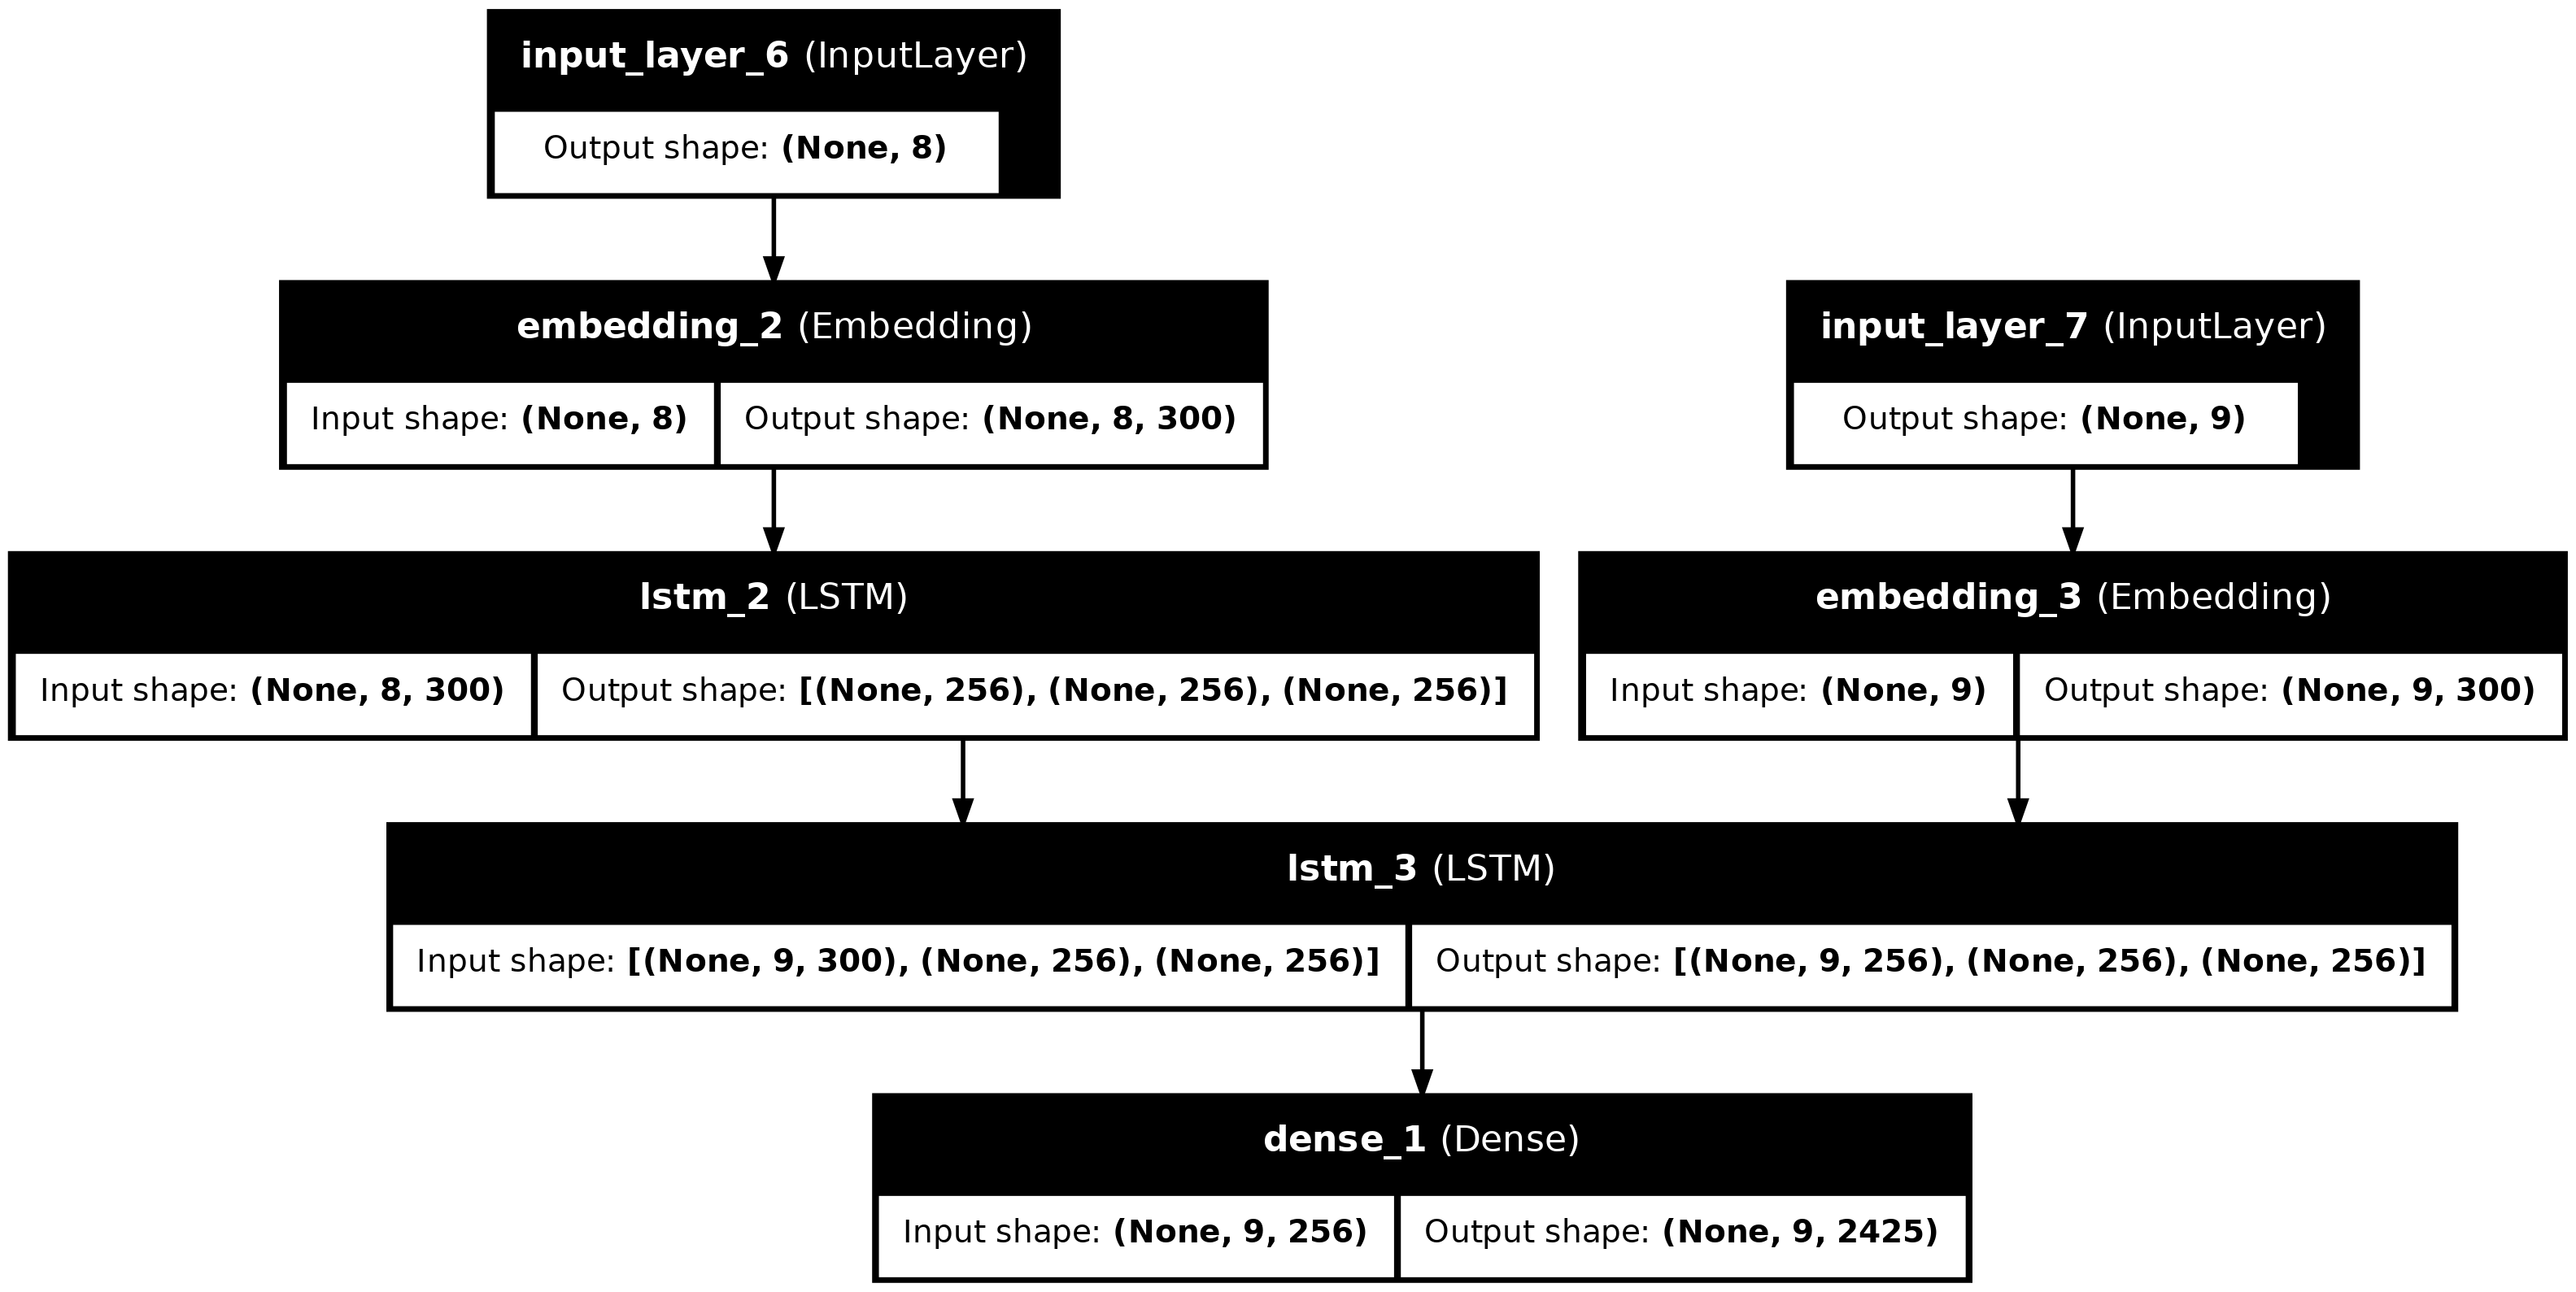

In [35]:
n_units = 256

# Define training encoder
encoder_inputs = Input(shape=(max_input_len,))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  
          output_dim=embed_dim,  
          weights=[embedding_matrix],  
          trainable=False
        )      

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=0.2)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# Define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=embed_dim, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Define the dense layers
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Se inicializa el modelo encoder.

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 8, 300)         │       724,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ [(None, 256), (None,   │       570,368 │
│                                 │ 256), (None, 256)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,294,568 (4.94 MB)

 Trainable params: 570,368 (2.18 MB)

 Non-trainable params: 724,200 (2.76 MB)

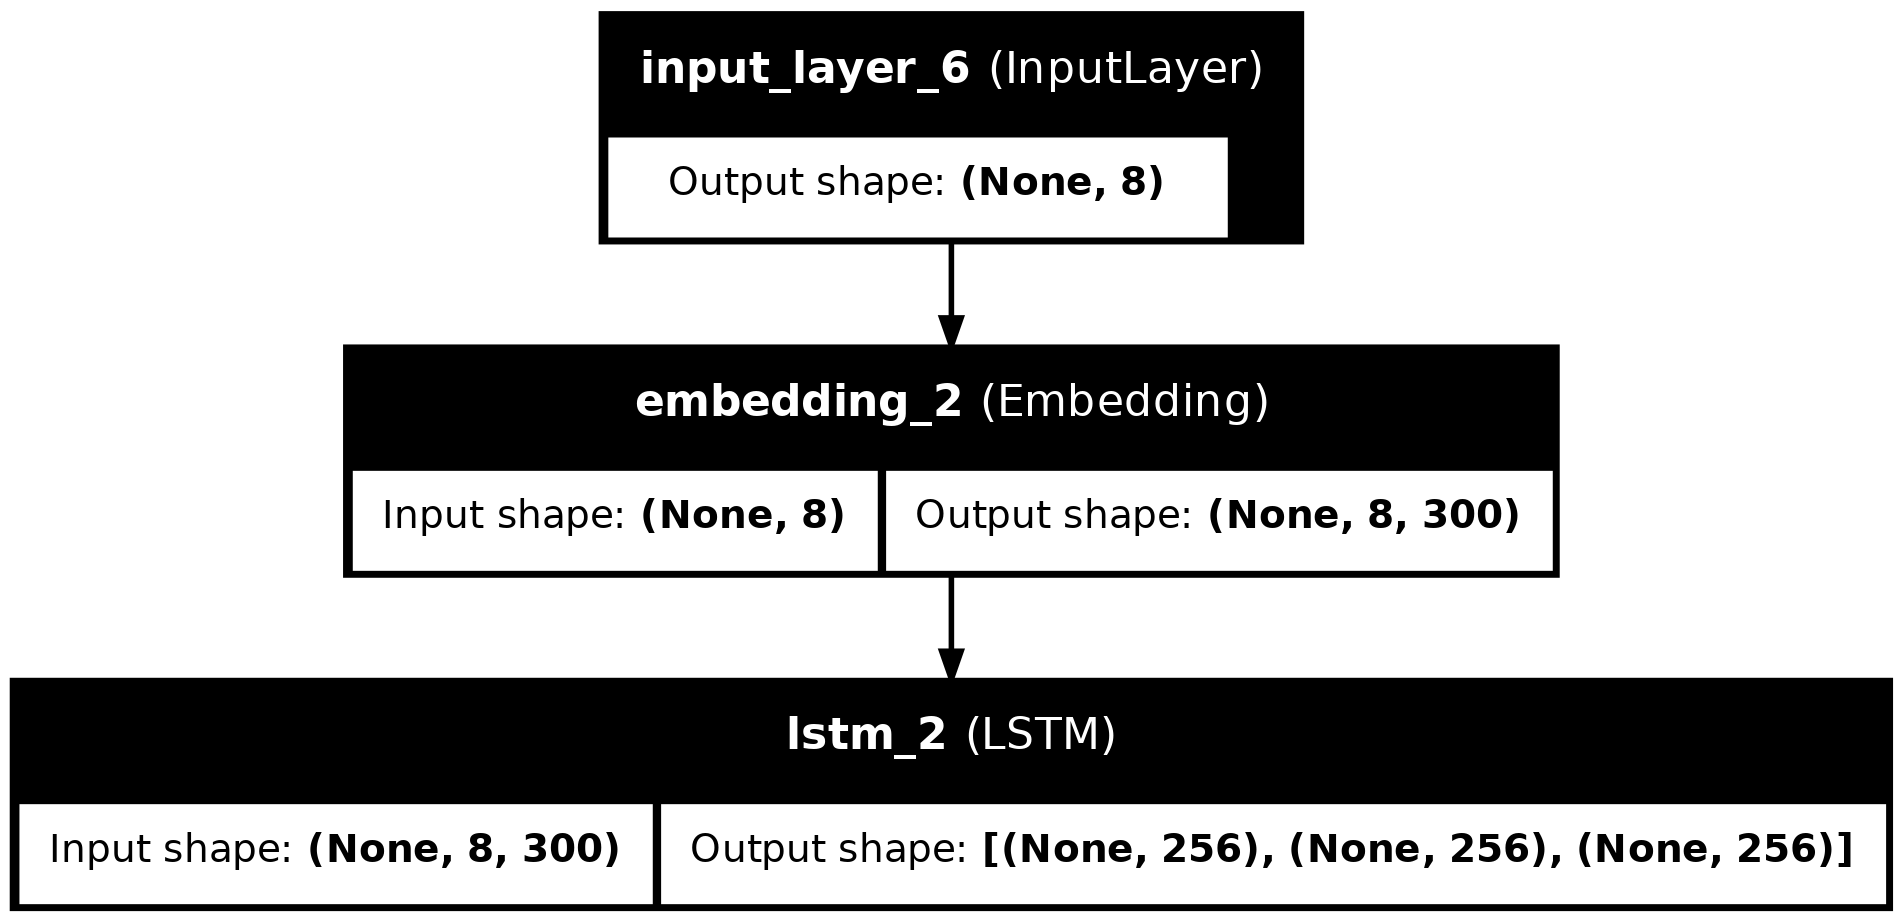

In [36]:
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()
plot_model(encoder_model, to_file='encoder_model_plot.png', show_shapes=True, show_layer_names=True)

Se inicializa el modelo decoder.

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 300)    │    727,500 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 1, 256),  │    570,368 │ embedding_3[1][0… │
│                     │ (None, 256),      │            │ input_layer_8[0]… │
│                     │ (None, 256)]      │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 2425)   │    623,225 │ lstm_3[1][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,921,093 (7.33 MB)

 Trainable params: 1,921,093 (7.33 MB)

 Non-trainable params: 0 (0.00 B)

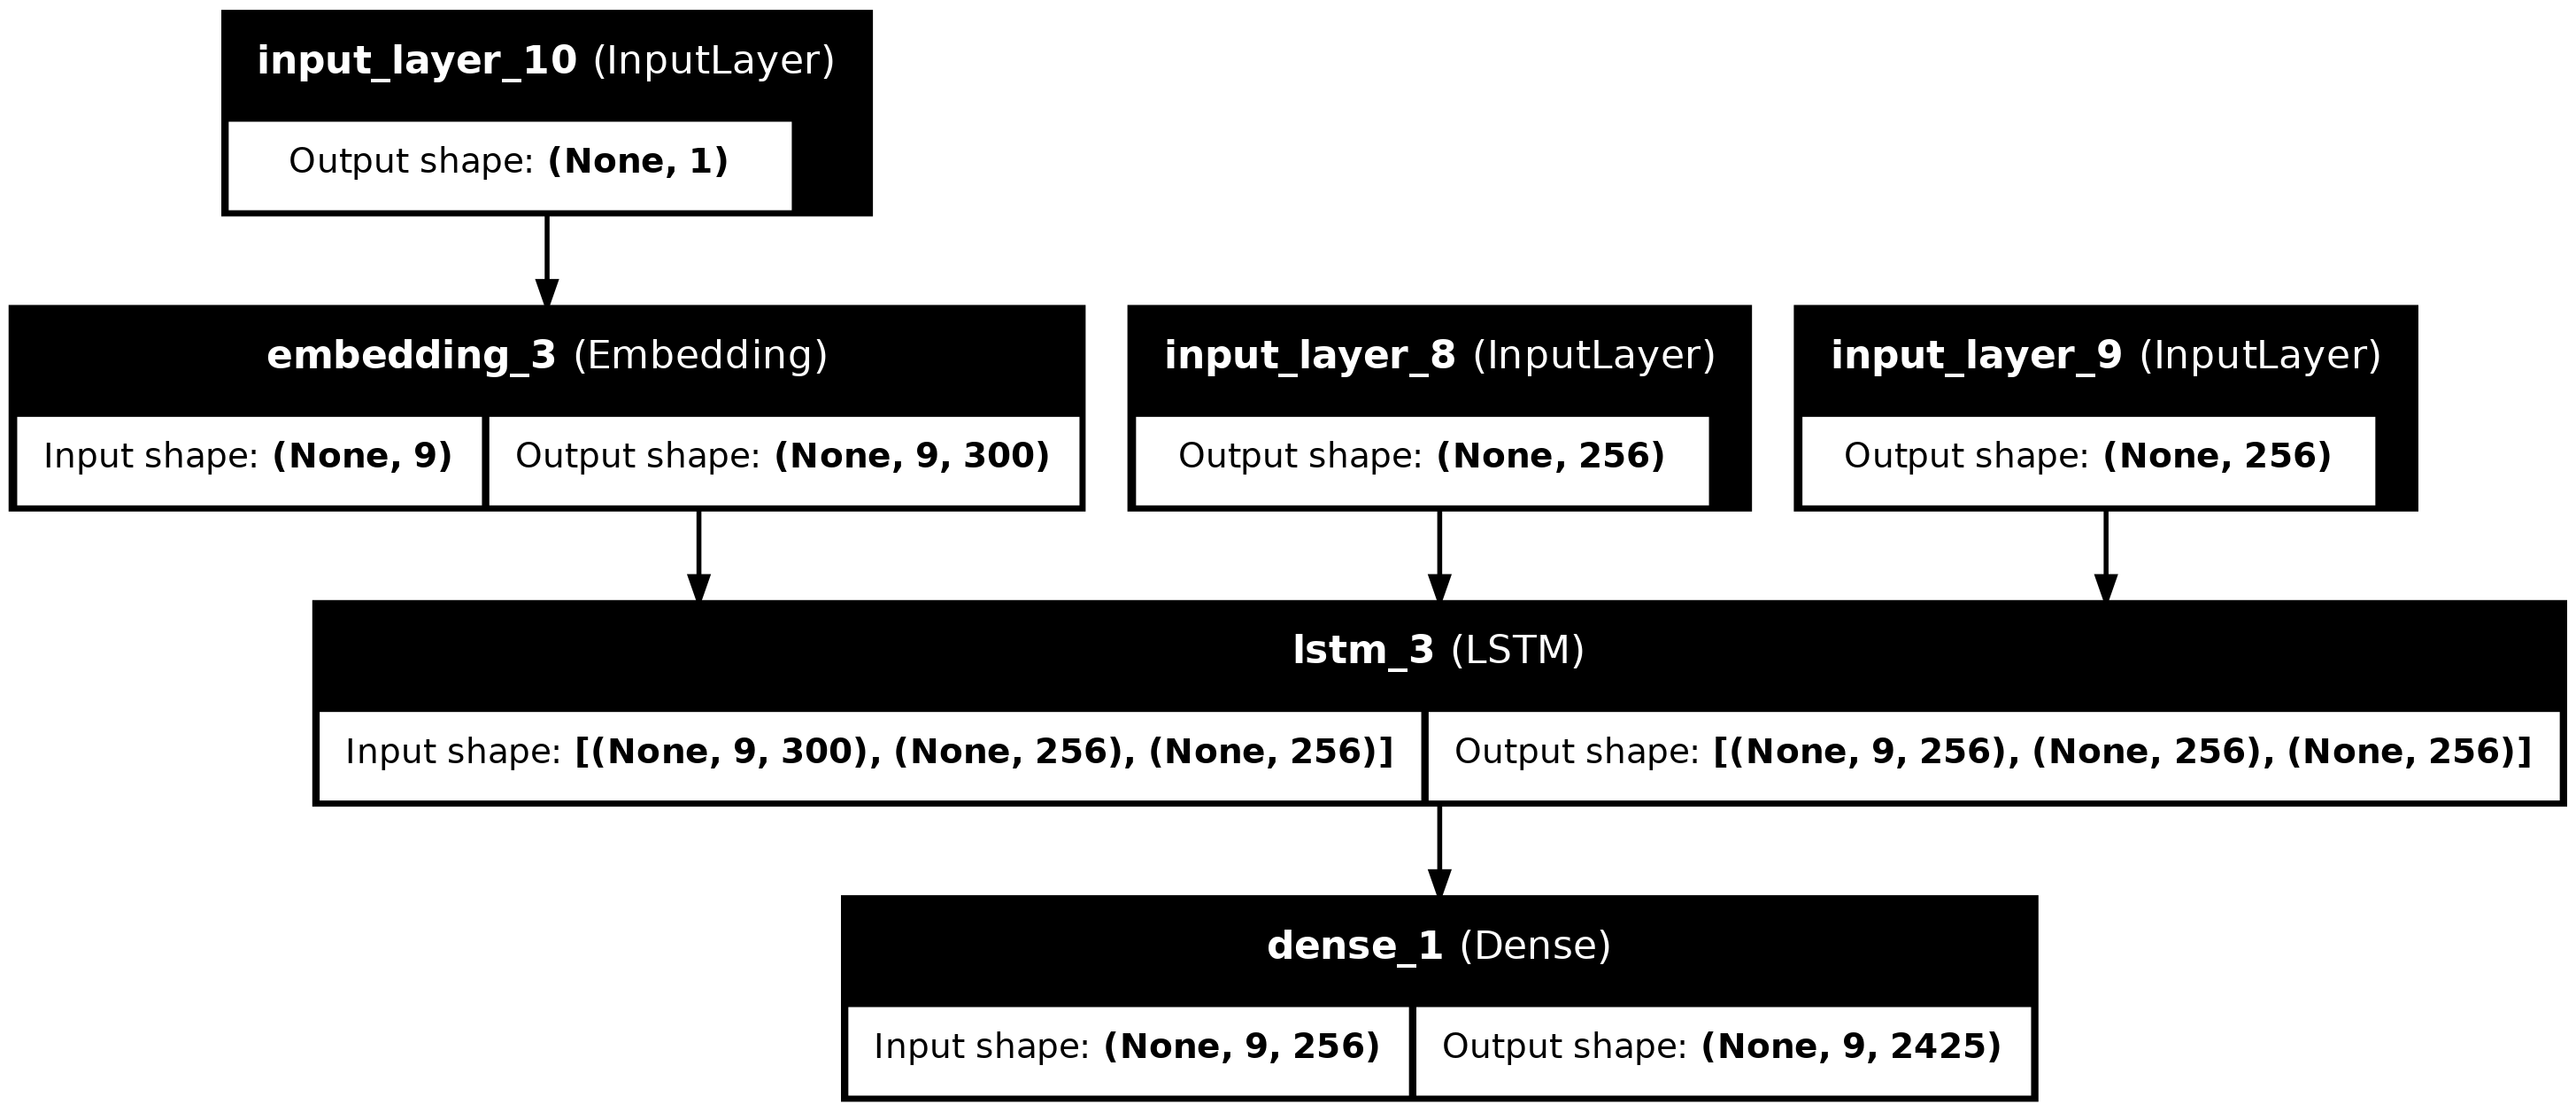

In [37]:
# Define the decoder's state inputs
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# The decoder will receive one word at a time during inference
decoder_inputs_single = Input(shape=(1,))

# Use the same embedding layer defined during training
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# LSTM for one time step with the previous states
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

# Updated states
decoder_states = [state_h, state_c]

# Dense layer
decoder_outputs = decoder_dense(decoder_outputs)

# Define the decoder inference model
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

decoder_model.summary()
plot_model(decoder_model, to_file='decoder_model_plot.png', show_shapes=True, show_layer_names=True)

Se define el entrenaiento del modelo. Adicionalmente, se consideran los siguientes callbacks: `ModelCheckpoint`, `EarlyStopping` y `ReduceLROnPlateau` en búsqueda de mejorar el modelo e ir guardando los mejores pesos.

In [241]:
# Early stopping to stop training if validation loss does not improve after 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint('qa_bot_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Reduce learning rate when the model's performance has plateaued
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Fit the model
history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    batch_size=32,
    epochs=45,
    validation_split=0.25,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
)

# Save the final model if needed (checkpoint will save the best one)
model.save('qa_bot_final_model.keras')

Epoch 1/45
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.5580 - loss: 2.8233
Epoch 1: val_loss improved from inf to 1.94083, saving model to qa_bot_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - categorical_accuracy: 0.5587 - loss: 2.8171 - val_categorical_accuracy: 0.6691 - val_loss: 1.9408 - learning_rate: 0.0100
Epoch 2/45
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.6906 - loss: 1.6099
Epoch 2: val_loss improved from 1.94083 to 1.93718, saving model to qa_bot_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.6906 - loss: 1.6100 - val_categorical_accuracy: 0.6712 - val_loss: 1.9372 - learning_rate: 0.0100
Epoch 3/45
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.7061 - loss: 1.3955
Epoch 3: val_loss did not improve from 1.93718
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7061 - loss: 1.3956 - val_categorical_accuracy: 0.6765 - val_loss: 1.9533 - 

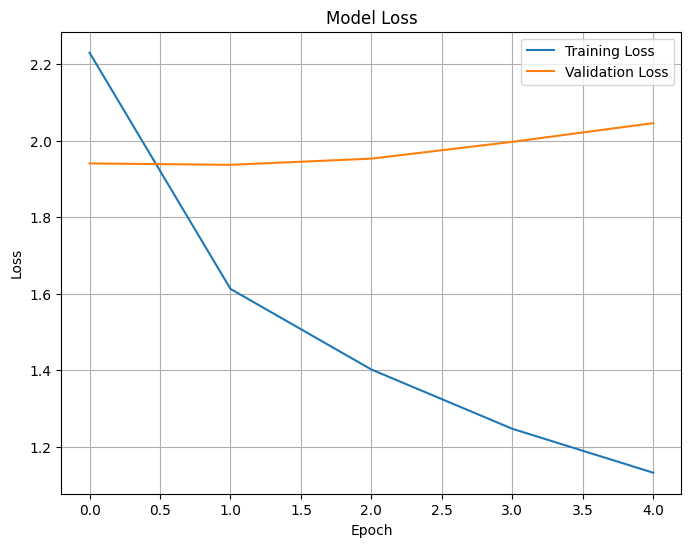

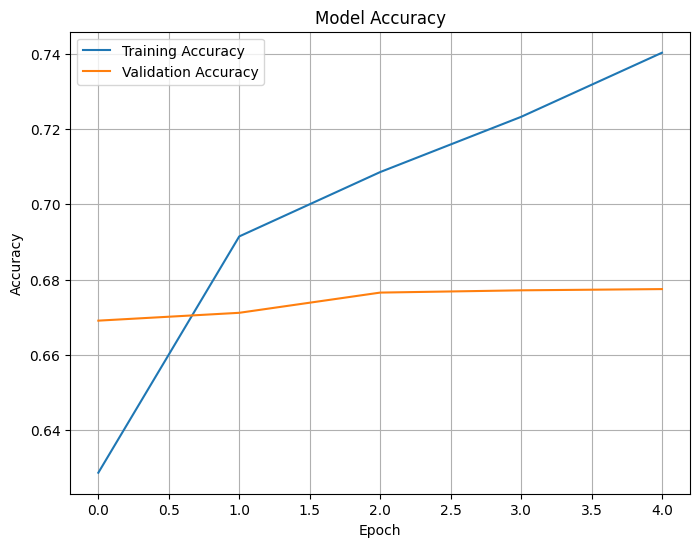

In [242]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

if 'categorical_accuracy' in history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

Se puede ver que el modelo cominza a entrar en overfitting bastante rápido, por lo que el early stopping detiene el entrenamiento a tiempo. El modelo no logra alcanzar un accuracy muy alto, después de muchos intentos, se piensa que esto se debe al tamaño del dataset. Sin embargo, como se mostrará en la siguiente sección, el modelo es capaz de responder preguntas de manera coherente.

## Inferencia

Finalmente, se probará la capacidad de inferencia del modelo entrenado. 

In [243]:
idx2word_inputs = {v: k for k, v in word2idx_inputs.items()}
idx2word_target = {v: k for k, v in word2idx_outputs.items()}

Se prueba con una secuencia de entrada aleatoria y se obtiene la respuesta correspondiente.

In [253]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
answer = generate_answer(
    input_seq=input_seq, 
    encoder_model=encoder_model, 
    decoder_model=decoder_model, 
    max_out_len=max_out_len, 
    word2idx_outputs=word2idx_outputs, 
    idx2word_target=idx2word_target
    )
print('-')
print('Input:', input_sentences[i])
print('Response:', answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted index: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted index: 2
-
Input: what do you do for a living
Response: i am a student


Se puede ver que la respuesta en este caso tiene sentido y es coherente con la pregunta realizada. Tambíen debe notarse que el modelo logra responder con cierta coherencia, formando una oración que tiene sentido.

In [245]:
input_test = "Where are you from?"
input_test_cleaned = clean_text(input_test)
print('Input:', input_test_cleaned)
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
print("Representacion en vector de tokens de ids", int_seq_test)
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_input_test)

# Generate the answer
answer = generate_answer(
    input_seq=encoder_input_test, 
    encoder_model=encoder_model, 
    decoder_model=decoder_model, 
    max_out_len=max_out_len, 
    word2idx_outputs=word2idx_outputs, 
    idx2word_target=idx2word_target
    )
print("Generated Answer:", answer)

Input: where are you from
Representacion en vector de tokens de ids [45, 10, 3, 38]
Padding del vector: [[ 0  0  0  0 45 10  3 38]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted index: 38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted index: 2
Generated Answer: i am from the us


En este caso podemos ver que la respuesta obtenida tiene una alta coherencia con la pregunta realizada, lo que indica un buen desempeño del modelo para este caso.

In [246]:
input_test = "Do you read?"
input_test_cleaned = clean_text(input_test)
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)

# Generate the answer
answer = generate_answer(
    input_seq=encoder_input_test, 
    encoder_model=encoder_model, 
    decoder_model=decoder_model, 
    max_out_len=max_out_len, 
    word2idx_outputs=word2idx_outputs, 
    idx2word_target=idx2word_target
    )
print("Generated Answer:", answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted index: 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 2
Generated Answer: i like to go to the beach


En este caso la respuesta esta más alejada de la pregunta, pero sigue teniendo algo de sentido y la oración de respuesta esta bien estructurada.

In [247]:
input_test = "Do you have any pet?"
input_test_cleaned = clean_text(input_test)
print('Input:', input_test_cleaned)
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
print("Representacion en vector de tokens de ids", int_seq_test)
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_input_test)

# Generate the answer
answer = generate_answer(
    input_seq=encoder_input_test, 
    encoder_model=encoder_model, 
    decoder_model=decoder_model, 
    max_out_len=max_out_len, 
    word2idx_outputs=word2idx_outputs, 
    idx2word_target=idx2word_target
    )
print("Generated Answer:", answer)

Input: do you have any pet
Representacion en vector de tokens de ids [4, 3, 14, 31, 346]
Padding del vector: [[  0   0   0   4   3  14  31 346]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 2
Generated Answer: no


La respuesta es corta pero parece ser una respuesta válida y directa para la pregunta realizada. Ya se ha mostrado que el modelo tiene la capacidad de generar respuestas largas, por lo que en este caso la respuesta corta es un buen indicador de que el modelo esta respondiendo correctamente.

In [248]:
input_test = "Hello, how are you?"
input_test_cleaned = clean_text(input_test)
print('Input:', input_test_cleaned)
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
print("Representacion en vector de tokens de ids", int_seq_test)
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_input_test)

# Generate the answer
answer = generate_answer(
    input_seq=encoder_input_test, 
    encoder_model=encoder_model, 
    decoder_model=decoder_model, 
    max_out_len=max_out_len, 
    word2idx_outputs=word2idx_outputs, 
    idx2word_target=idx2word_target
    )
print("Generated Answer:", answer)

Input: hello how are you
Representacion en vector de tokens de ids [27, 13, 10, 3]
Padding del vector: [[ 0  0  0  0 27 13 10  3]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 2
Generated Answer: i am fine


## Entrenamiento e inferencia del segundo modelo

En este último caso, la respuesta obtenida tiene coherencia con la pregunta realizada. 

I0000 00:00:1729397494.685482  221738 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729397494.685798  221738 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729397494.686046  221738 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729397494.839919  221738 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729397494.840092  221738 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-20

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 8, 300)    │    724,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 8, 1024), │  3,330,048 │ embedding[0][0]   │
│ (Bidirectional)     │ (None, 512),      │            │                   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 9, 300)    │    727,500 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1024)      │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1024)      │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 9, 1024), │  5,427,200 │ embedding_1[0][0… │
│                     │ (None, 1024),     │            │ concatenate[0][0… │
│                     │ (None, 1024)]     │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 9, 1024)   │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 9, 2048)   │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 9, 2425)   │  4,968,825 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,177,773 (57.90 MB)

 Trainable params: 14,453,573 (55.14 MB)

 Non-trainable params: 724,200 (2.76 MB)

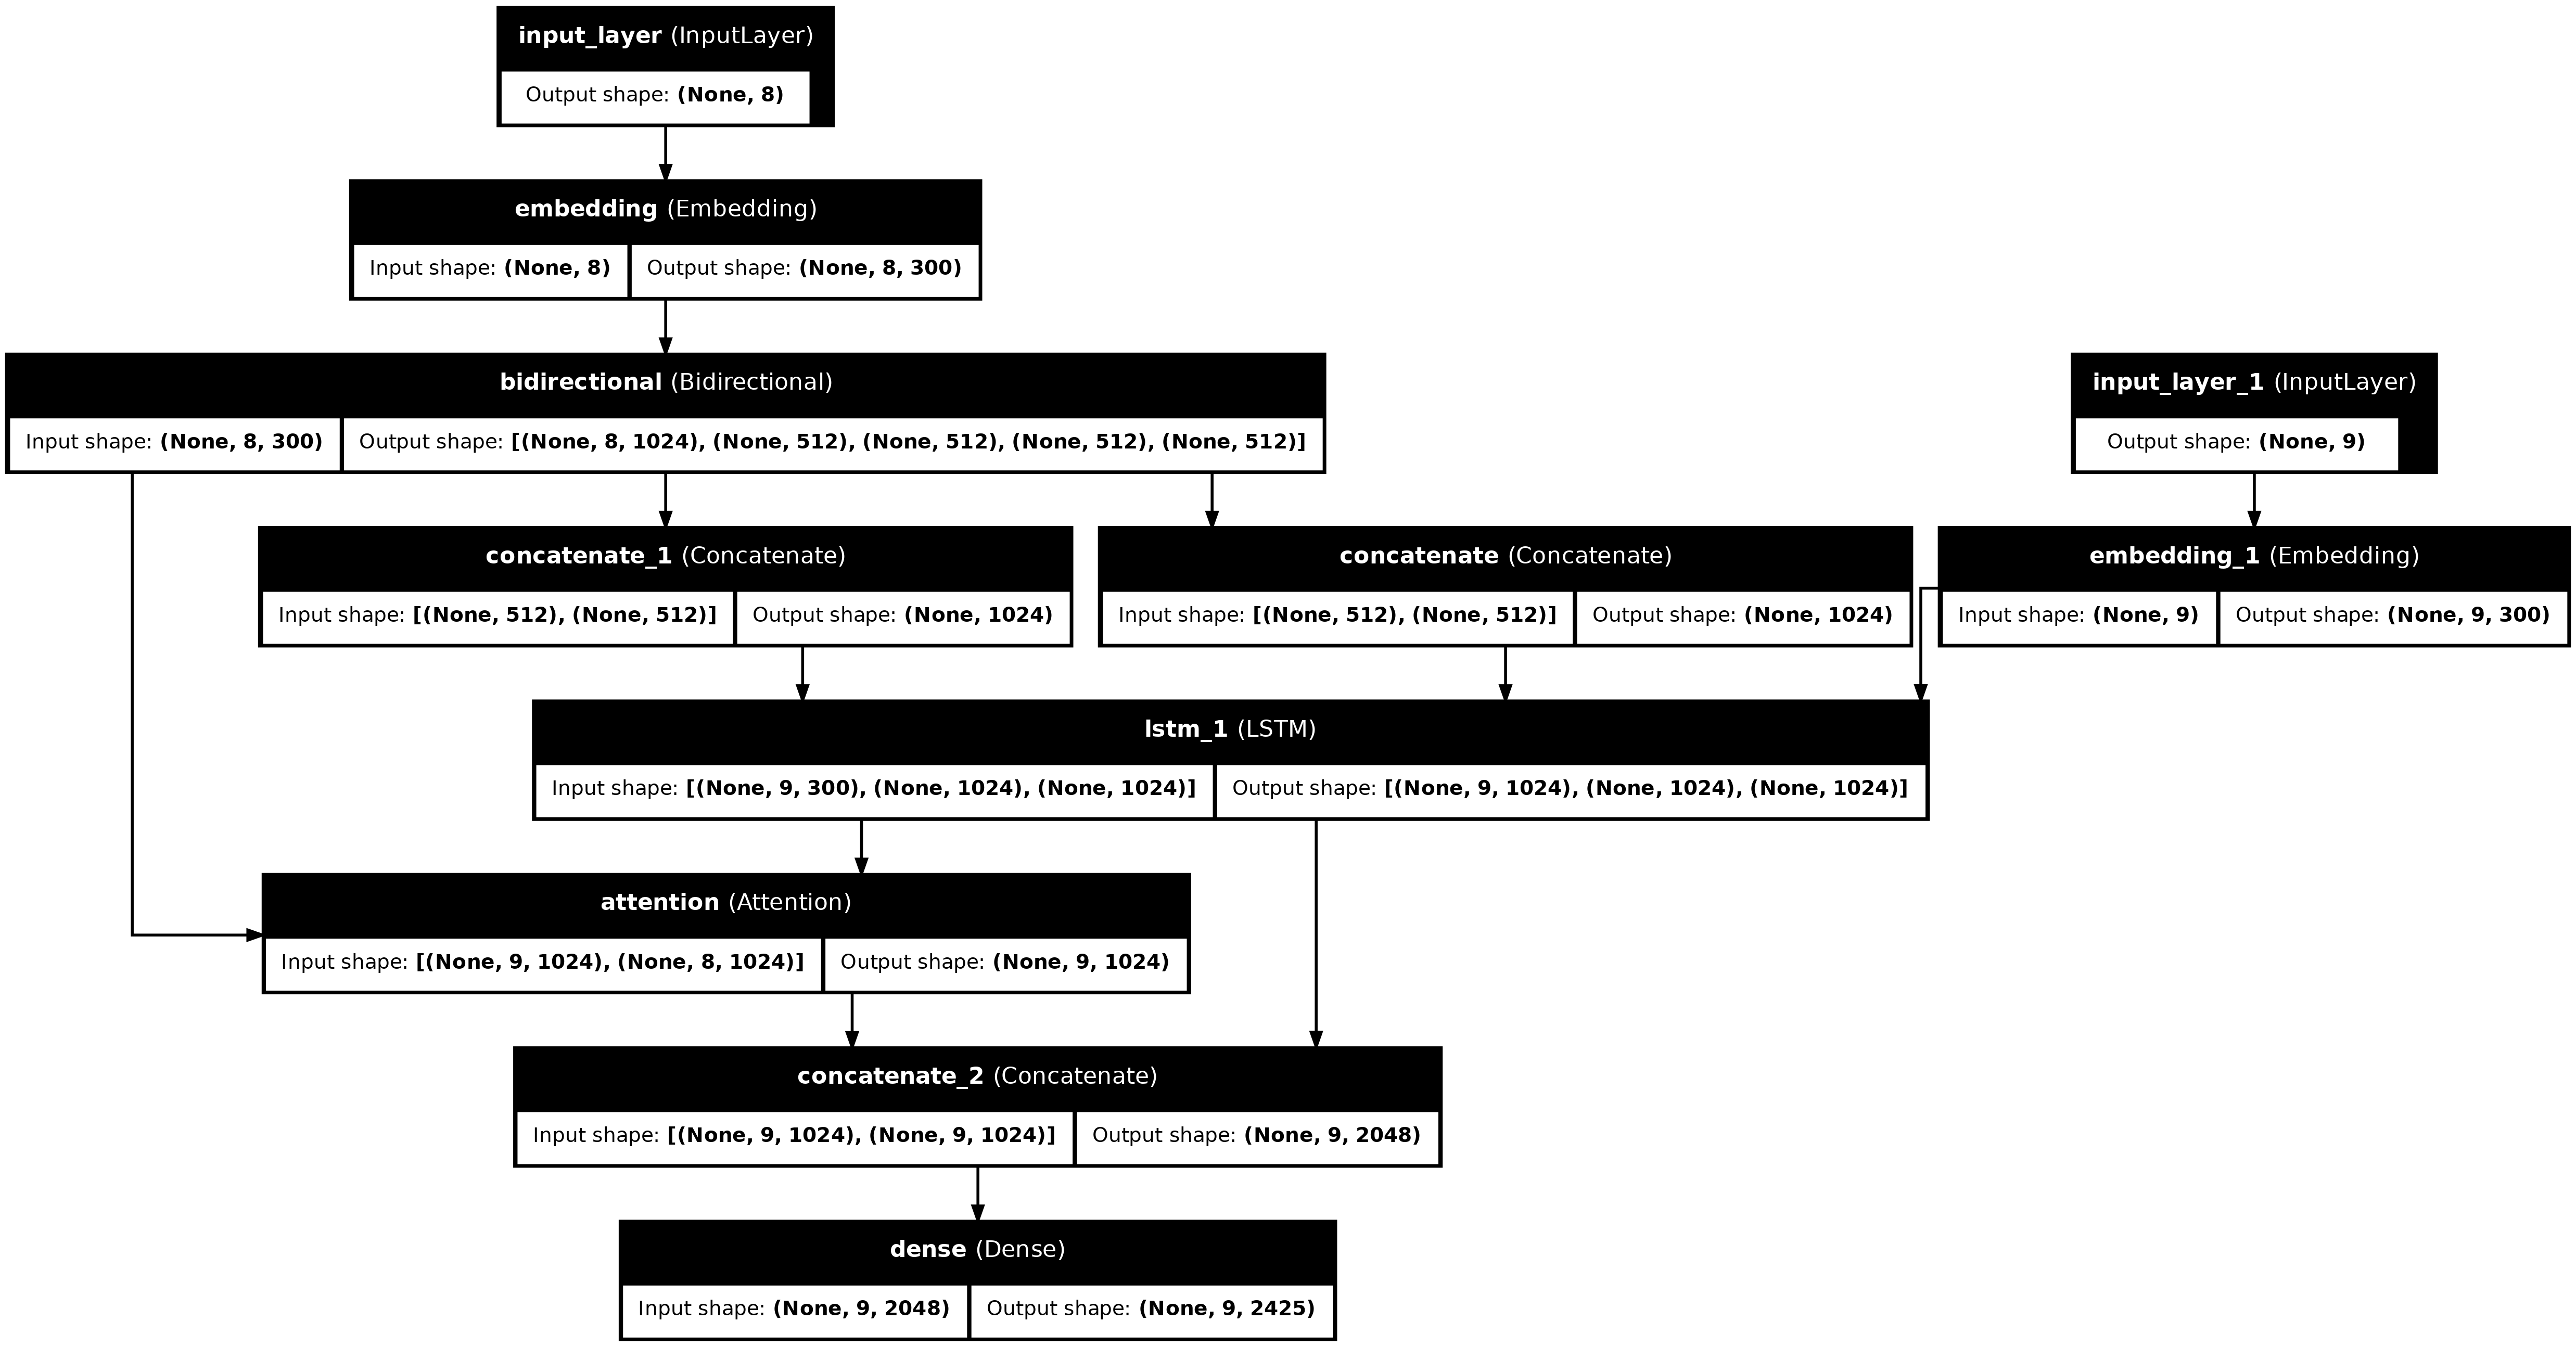

In [15]:
n_units = 512

# Define training encoder
encoder_inputs = Input(shape=(max_input_len,))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  
          output_dim=embed_dim,  
          weights=[embedding_matrix],  
          trainable=False
        )      

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

# The encoder now uses a Bidirectional LSTM
encoder = Bidirectional(LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs_x)

# Concatenate the forward and backward states
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=embed_dim)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units * 2, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Attention layer
attention = Attention()
attention_output = attention([decoder_outputs, encoder_outputs])

# Concatenate attention output with decoder LSTM outputs
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Define the dense layer
decoder_dense = Dense(num_words_output, activation='softmax', kernel_regularizer=l2(0.01))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

# Summarize the model
model.summary()
plot_model(model, to_file='model_plot_with_bidirectional_attention.png', show_shapes=True, show_layer_names=True)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 8, 300)    │    724,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 8, 1024), │  3,330,048 │ embedding[0][0]   │
│ (Bidirectional)     │ (None, 512),      │            │                   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1024)      │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1024)      │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,054,248 (15.47 MB)

 Trainable params: 3,330,048 (12.70 MB)

 Non-trainable params: 724,200 (2.76 MB)

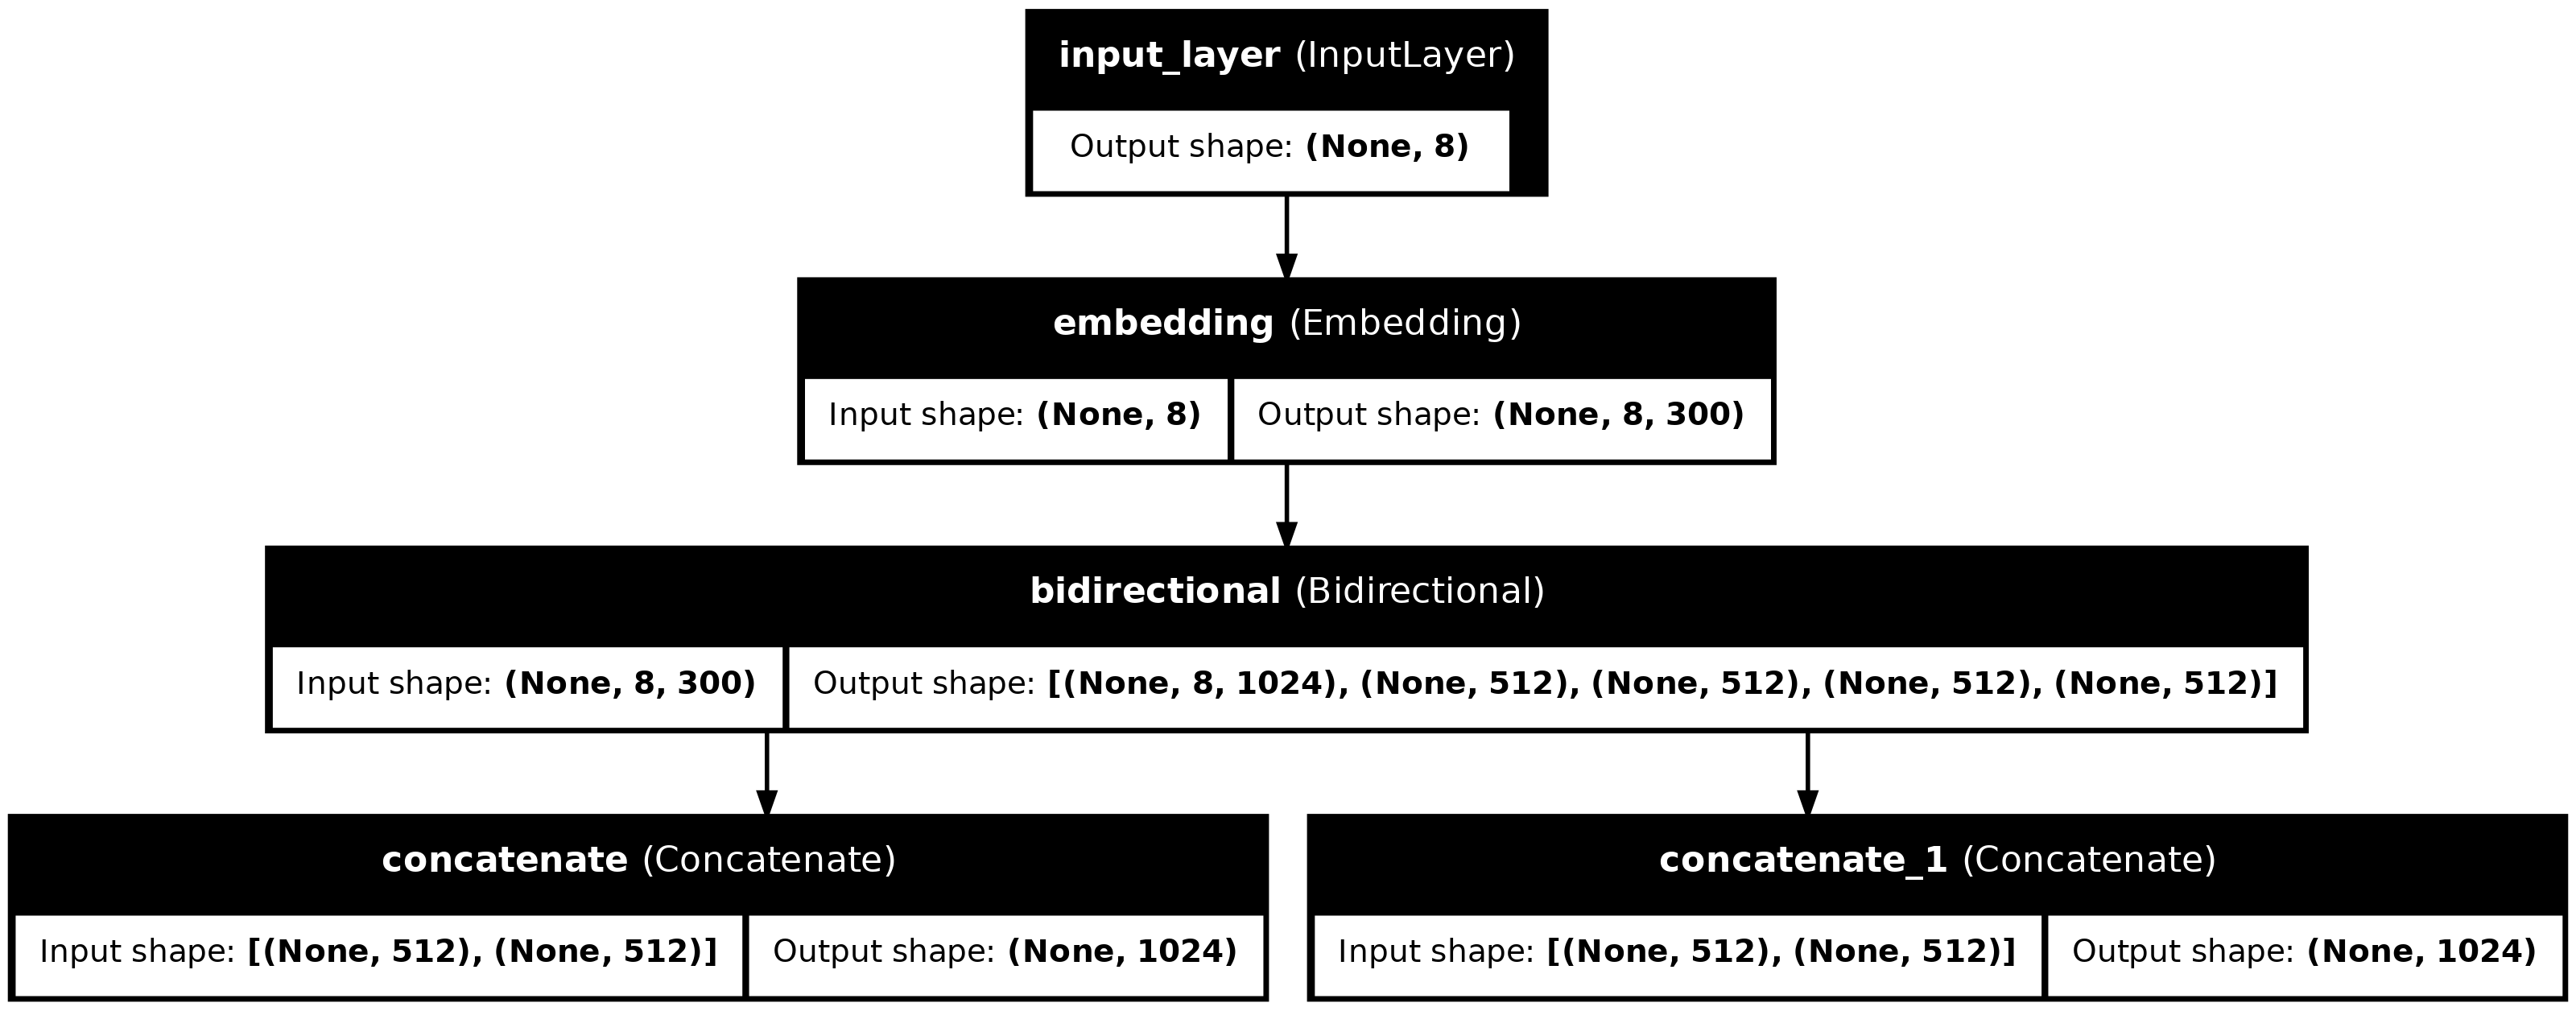

In [16]:
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])
encoder_model.summary()
plot_model(encoder_model, to_file='encoder_model_plot_with_attention.png', show_shapes=True, show_layer_names=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 300)    │    727,500 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 1024), │  5,427,200 │ embedding_1[1][0… │
│                     │ (None, 1024),     │            │ input_layer_2[0]… │
│                     │ (None, 1024)]     │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 8, 1024)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 1, 1024)   │          0 │ lstm_1[1][0],     │
│ (Attention)         │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1, 2048)   │          0 │ lstm_1[1][0],     │
│ (Concatenate)       │                   │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 2425)   │  4,968,825 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,123,525 (42.43 MB)

 Trainable params: 11,123,525 (42.43 MB)

 Non-trainable params: 0 (0.00 B)

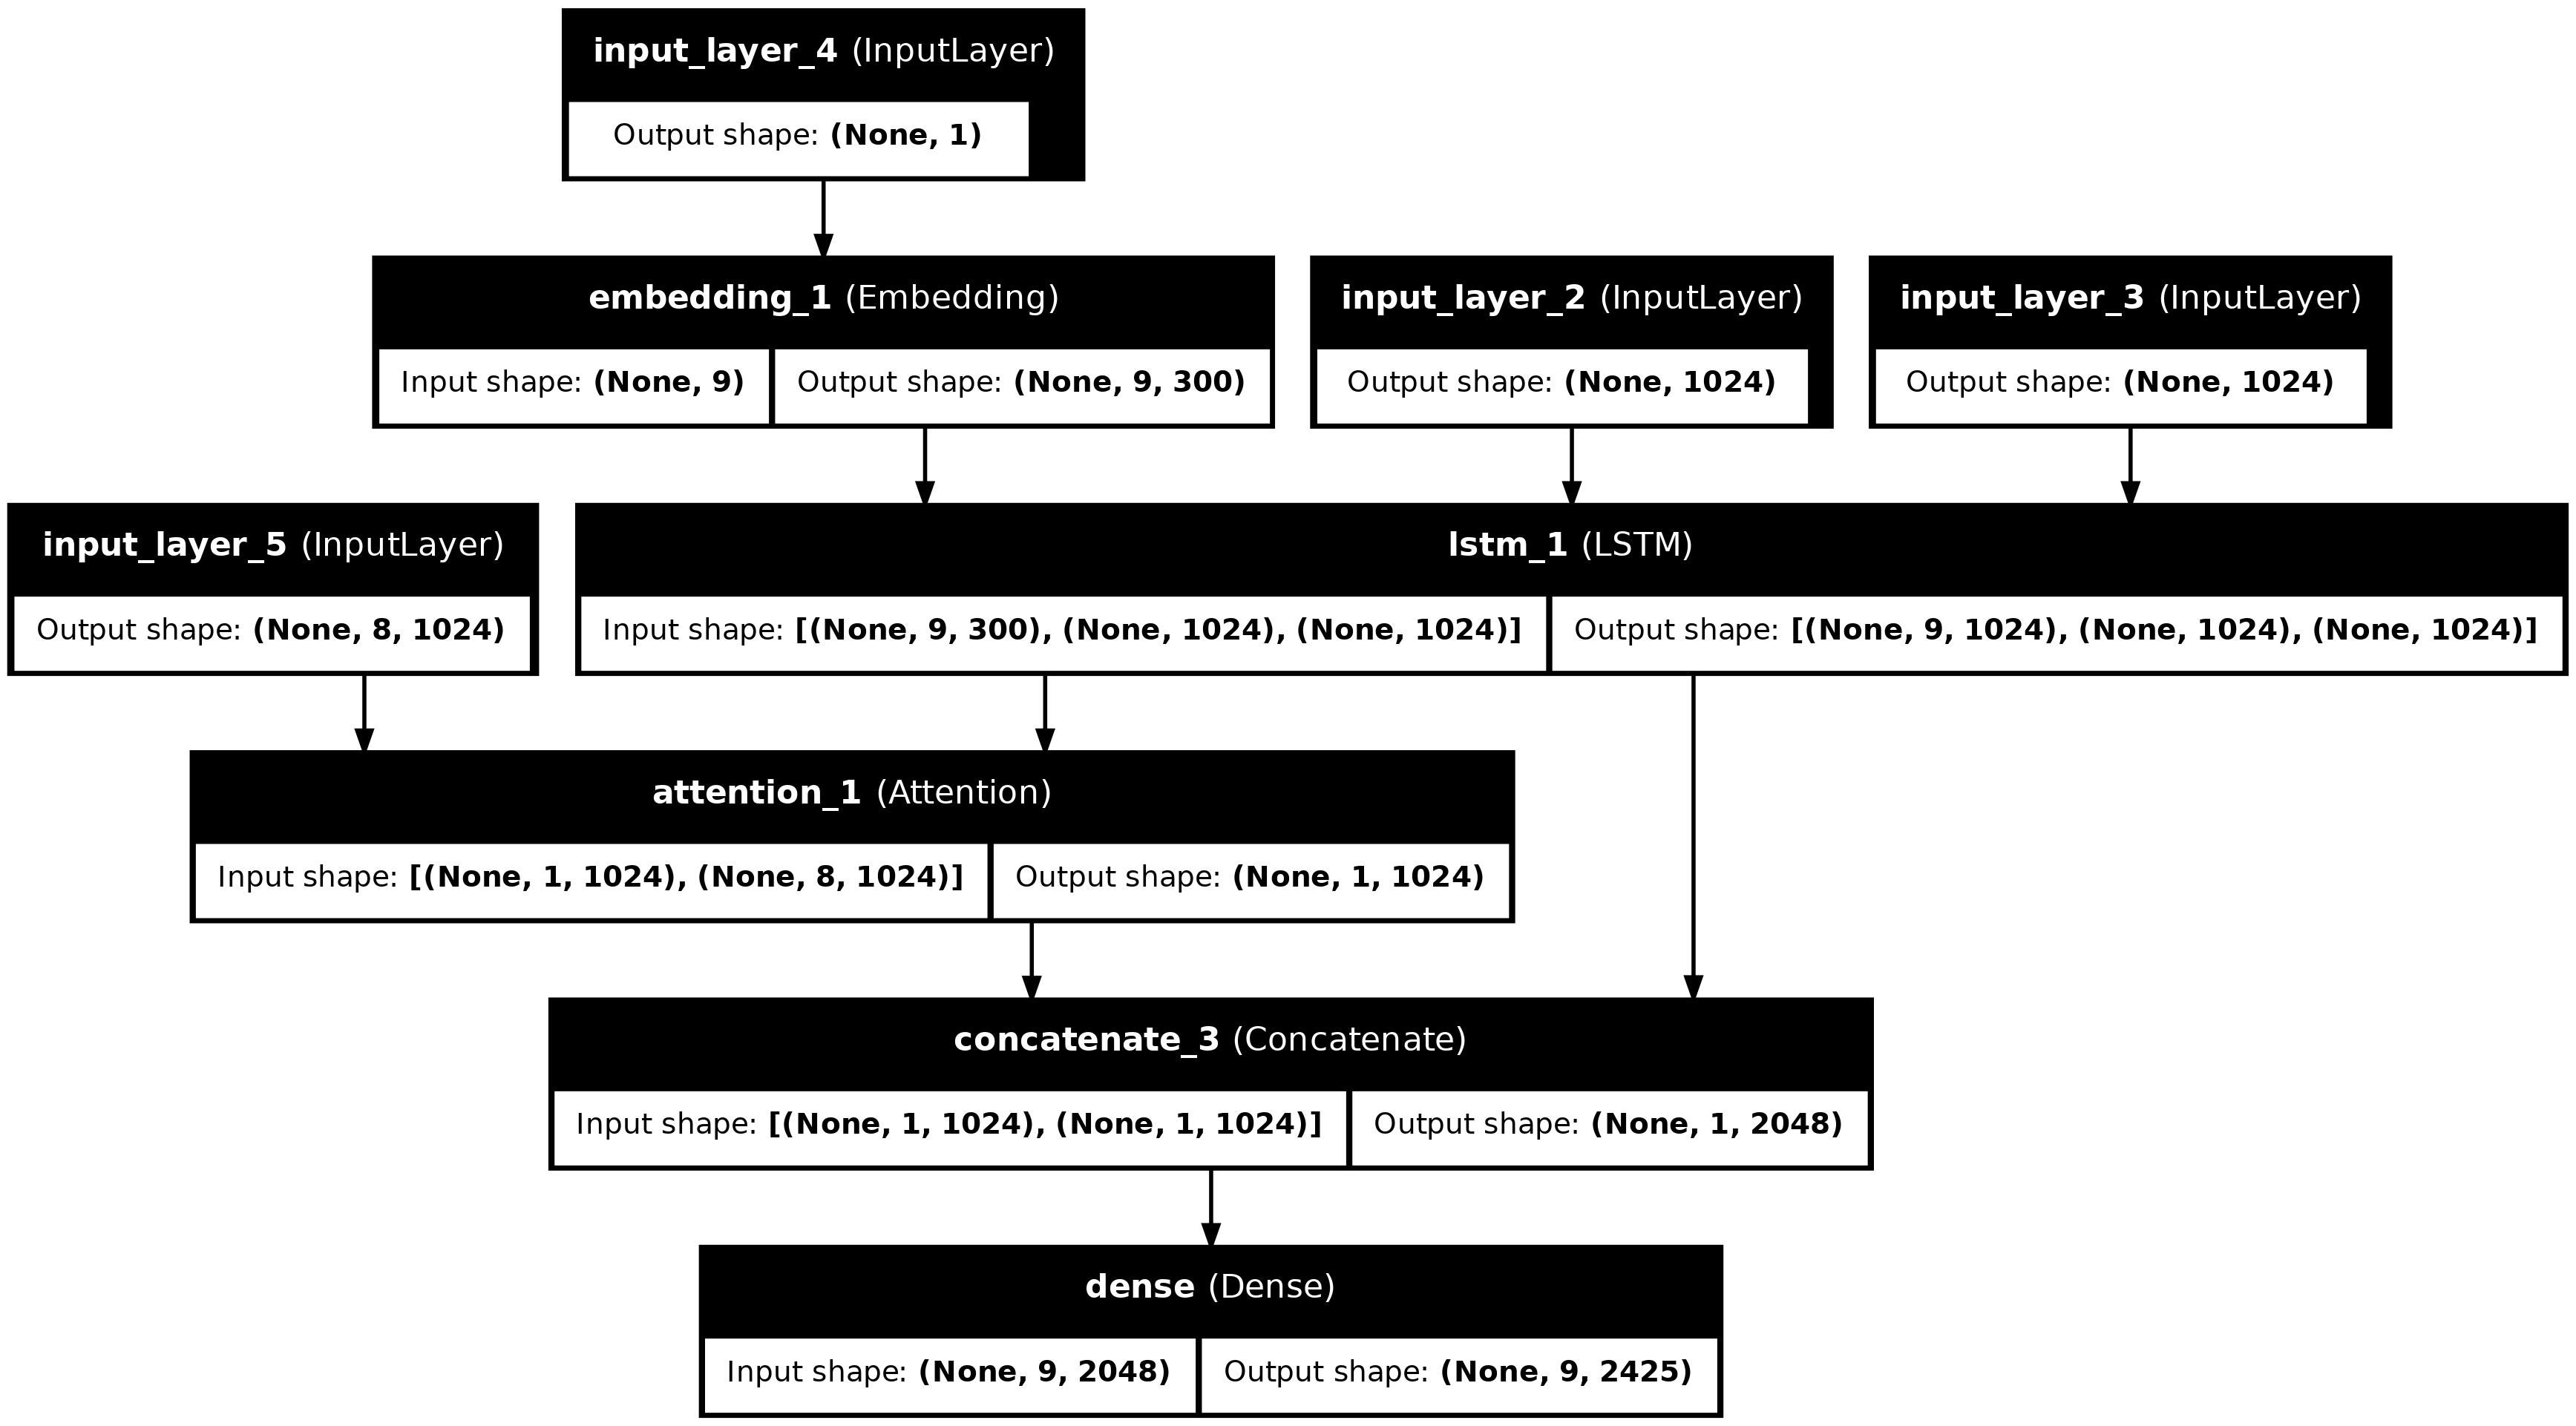

In [17]:
# Define the decoder's state inputs
decoder_state_input_h = Input(shape=(n_units * 2,))
decoder_state_input_c = Input(shape=(n_units * 2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# The decoder will receive one word at a time during inference
decoder_inputs_single = Input(shape=(1,))

# Use the same embedding layer defined during training
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# LSTM for one time step with the previous states
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

# Define encoder outputs as input to attention during inference
encoder_outputs_inf = Input(shape=(max_input_len, n_units * 2))

# Attention layer for inference
attention_inf = Attention()
attention_output_inf = attention_inf([decoder_outputs, encoder_outputs_inf])

# Concatenate attention output with decoder LSTM outputs
decoder_concat_input_inf = Concatenate(axis=-1)([decoder_outputs, attention_output_inf])

# Dense layer for generating probabilities
decoder_outputs = decoder_dense(decoder_concat_input_inf)

# Define the decoder inference model
decoder_model = Model(
    [decoder_inputs_single, encoder_outputs_inf] + decoder_states_inputs,
    [decoder_outputs, state_h, state_c]
)

decoder_model.summary()
plot_model(decoder_model, to_file='decoder_model_with_attention.png', show_shapes=True, show_layer_names=True)


In [18]:
# Early stopping to stop training if validation loss does not improve after 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint('qa_bot_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Reduce learning rate when the model's performance has plateaued
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Fit the model
history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    batch_size=64,
    epochs=45,
    validation_split=0.25,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
)

# Save the final model if needed (checkpoint will save the best one)
model.save('qa_bot_final_model_attention.keras')

Epoch 1/45


2024-10-20 00:11:40.337946: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_accuracy: 0.4368 - loss: 11.1021
Epoch 1: val_loss improved from inf to 2.68475, saving model to qa_bot_best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - categorical_accuracy: 0.4389 - loss: 10.9332 - val_categorical_accuracy: 0.5784 - val_loss: 2.6848 - learning_rate: 0.0010
Epoch 2/45
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.6026 - loss: 2.5462
Epoch 2: val_loss improved from 2.68475 to 2.42360, saving model to qa_bot_best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - categorical_accuracy: 0.6029 - loss: 2.5444 - val_categorical_accuracy: 0.6329 - val_loss: 2.4236 - learning_rate: 0.0010
Epoch 3/45
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.6462 - loss: 2.3037
Epoch 3: val_loss improved from 2.42360 to 2.36477, saving model to qa_bot_best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - categorical_accuracy: 0.6463 - loss: 2.3033 - val_categorical_accuracy: 0.64

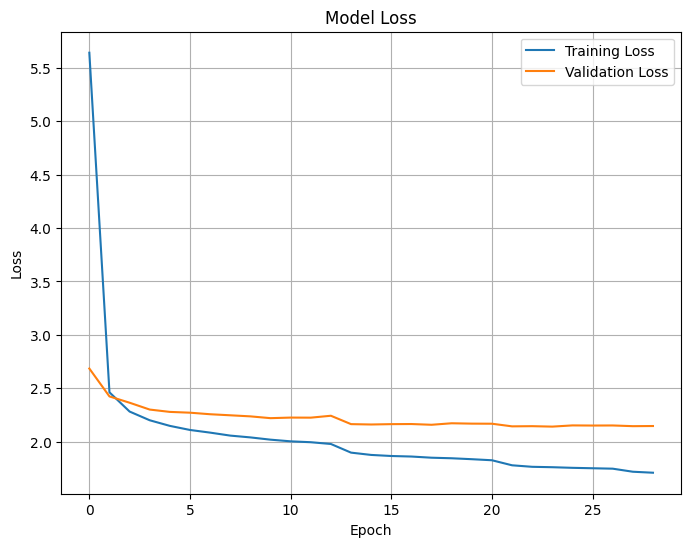

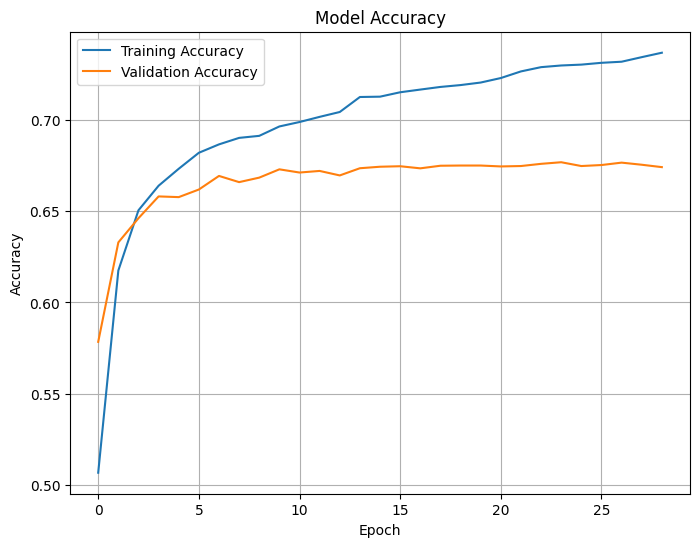

In [19]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

if 'categorical_accuracy' in history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

Con la nueva arquitectura de modelo planteda, se puede ver que la entrada al overfitting es mucho más lenta y el accuracy obtenido es mayor. Sin embargo, el early stopping sigue siendo necesario para evitar el overfitting, y salta en la época 30. A pesar de esto, el modelo sigue siendo capaz de responder preguntas de manera coherente.

In [20]:
idx2word_inputs = {v: k for k, v in word2idx_inputs.items()}
idx2word_target = {v: k for k, v in word2idx_outputs.items()}

Se prueba con una secuencia de entrada aleatoria y se obtiene la respuesta correspondiente.

In [23]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
answer = generate_answer_with_attention(
    input_seq=input_seq, 
    encoder_model=encoder_model, 
    decoder_model=decoder_model, 
    max_out_len=max_out_len, 
    word2idx_outputs=word2idx_outputs, 
    idx2word_target=idx2word_target
    )
print('-')
print('Input:', input_sentences[i])
print('Response:', answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted index: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted index: 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted index: 2
-
Input: i am fine and you
Response: i am good


La respuesta obtenida tiene sentido y es coherente con la pregunta realizada. 

In [27]:
input_test = "Where are you from?"
input_test_cleaned = clean_text(input_test)
print('Input:', input_test_cleaned)
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
print("Representacion en vector de tokens de ids", int_seq_test)
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_input_test)

# Generate the answer
answer = generate_answer_with_attention(
    input_seq=encoder_input_test, 
    encoder_model=encoder_model, 
    decoder_model=decoder_model, 
    max_out_len=max_out_len, 
    word2idx_outputs=word2idx_outputs, 
    idx2word_target=idx2word_target
    )
print("Generated Answer:", answer)

Input: where are you from
Representacion en vector de tokens de ids [45, 10, 3, 38]
Padding del vector: [[ 0  0  0  0 45 10  3 38]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted index: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted index: 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted index: 69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted index: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted index: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted index: 84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted index: 2
Generated Answer: i am not sure what you mean


La respuesta obtenida no es la esperada. A diferencia del modelo anterior, en este caso el modelo tiene un desempeño peor.

In [28]:
input_test = "Do you read?"
input_test_cleaned = clean_text(input_test)
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)

# Generate the answer
answer = generate_answer_with_attention(
    input_seq=encoder_input_test, 
    encoder_model=encoder_model, 
    decoder_model=decoder_model, 
    max_out_len=max_out_len, 
    word2idx_outputs=word2idx_outputs, 
    idx2word_target=idx2word_target
    )
print("Generated Answer:", answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted index: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted index: 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted index: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted index: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted index: 27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted index: 2
Generated Answer: i do not like to read


Respecto a la respuesta del modelo anterior, en este caso la respuesta es más coherente con la pregunta realizada, ya que menciona la palabra "read" que ya había sido mencionada en la pregunta, y además de manera correcta.

In [34]:
input_test = "Do you have any pet?"
input_test_cleaned = clean_text(input_test)
print('Input:', input_test_cleaned)
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
print("Representacion en vector de tokens de ids", int_seq_test)
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_input_test)

# Generate the answer
answer = generate_answer_with_attention(
    input_seq=encoder_input_test, 
    encoder_model=encoder_model, 
    decoder_model=decoder_model, 
    max_out_len=max_out_len, 
    word2idx_outputs=word2idx_outputs, 
    idx2word_target=idx2word_target
    )
print("Generated Answer:", answer)

Input: do you have any pet
Representacion en vector de tokens de ids [4, 3, 14, 31, 346]
Padding del vector: [[  0   0   0   4   3  14  31 346]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted index: 37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted index: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted index: 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted index: 2
Generated Answer: no i do not


En este caso la respuesta es más larga, y tiene un poco más de sentido que la respuesta obtenida con el modelo anterior. 

In [30]:
input_test = "Hello, how are you?"
input_test_cleaned = clean_text(input_test)
print('Input:', input_test_cleaned)
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
print("Representacion en vector de tokens de ids", int_seq_test)
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_input_test)

# Generate the answer
answer = generate_answer_with_attention(
    input_seq=encoder_input_test, 
    encoder_model=encoder_model, 
    decoder_model=decoder_model, 
    max_out_len=max_out_len, 
    word2idx_outputs=word2idx_outputs, 
    idx2word_target=idx2word_target
    )
print("Generated Answer:", answer)

Input: hello how are you
Representacion en vector de tokens de ids [27, 13, 10, 3]
Padding del vector: [[ 0  0  0  0 27 13 10  3]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted index: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted index: 47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted index: 2
Generated Answer: i am fine


La respuesta vuelve a ser coherente con la pregunta realizada.

In [32]:
input_test = "Hello, do you play any sports?"
input_test_cleaned = clean_text(input_test)
print('Input:', input_test_cleaned)
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
print("Representacion en vector de tokens de ids", int_seq_test)
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_input_test)

# Generate the answer
answer = generate_answer_with_attention(
    input_seq=encoder_input_test, 
    encoder_model=encoder_model, 
    decoder_model=decoder_model, 
    max_out_len=max_out_len, 
    word2idx_outputs=word2idx_outputs, 
    idx2word_target=idx2word_target
    )
print("Generated Answer:", answer)

Input: hello do you play any sports
Representacion en vector de tokens de ids [27, 4, 3, 43, 31, 263]
Padding del vector: [[  0   0  27   4   3  43  31 263]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted index: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted index: 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted index: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted index: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted index: 2
Generated Answer: i do not like to


En este caso la respuesta es mejor que la obtenida con el modelo anterior.